In [7]:
# IMPORTS
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
from numpy.linalg import lstsq

from scipy import interpolate
from scipy import signal
from sklearn.preprocessing import PolynomialFeatures

import csv   
import matplotlib.pyplot as plt
import pandas as pd
import json

In [8]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/VanderPol_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)
dt = np.mean(np.diff(t))

In [15]:
## Define functions
def kernel_weights(u,kernel_type = 'None'):
    
    if kernel_type == 'Epanechnikov':
        w = 3 / 4 *(1 - u **2)
    else:
        w = np.ones(len(u))

    return w

def locpoly_reg(y, t, t0, degree = 2, h = 1, kernel = 'None'):
    
    t_t0 = t - t0
    nn_indx = np.argwhere(abs(t_t0) < h)
    nn = len(nn_indx)
    y_nn = y[nn_indx]
    t_nn = t_t0[nn_indx]
    t_lpr = t[nn_indx]

    #Basis matrix of polynomial degree d
    poly = PolynomialFeatures(degree)
    B = poly.fit_transform(t_nn)

    #Compute the weights according to specific kernel function
    u = t_nn / h
    w = kernel_weights(u.flatten(), kernel)
    W = np.diag(w)

    #Solve local polynomail regression
    WB = np.dot(W,B)
    Wy = np.dot(W,y_nn)
    theta = lstsq(WB, Wy, rcond=-1)[0]
    y_lpr = np.dot(B,theta)
    
    #Compute the residual sum  of squares (SSE)
    SSE = norm(y_nn - y_lpr)**2

    #Compute the smoother matrix and degrees of freedom
    BtWB = np.dot(B.T,WB)
    K = lstsq(BtWB,B.T, rcond=-1)[0]
    Sh = np.dot(B,K)
    df = np.trace(Sh)
    
    #Compute GCV function
    GCVh = nn * SSE / (nn - df)**2
    
    return [(theta[0], theta[1]), (t_lpr, y_lpr), (SSE, df, nn), GCVh]

In [16]:
## Define parameters and allocate variables

#Range of bandwidths
hmin = 5 * dt
hmax = 1 * t[-1]
dh = dt
h_range = np.arange(hmin,hmax,dh)
n_h = len(h_range)

#Degree of the local polynomial
poly_d = 2

#Kernel type
# kernel_type = 'Epanechnikov'
kernel_type = 'none'
#Variable allocation
x_hat_h = np.zeros((t_samples,n_h))

#Save results
write_data = True

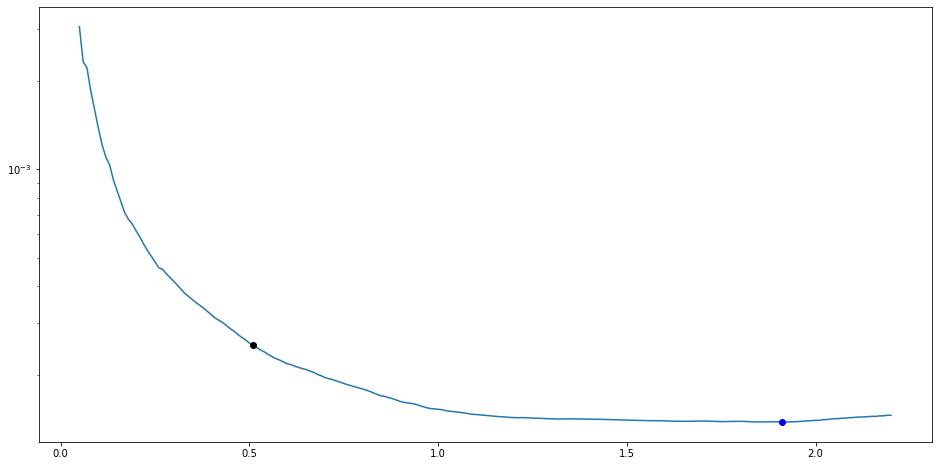

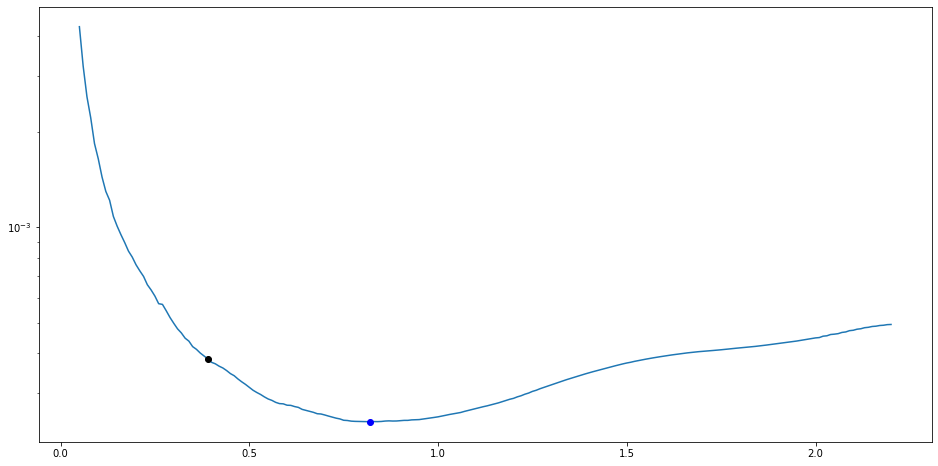

In [17]:

# LOAD OBSERVATION SAMPLES
Y_samples = []
noise = 0.01
noise_lvl = str(noise)
realization = 0

gcv_dict = {}

for state in range(n_states):

    filepath = 'data_files/VanderPol_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')

    Y_samples.append(y)

n_realizations = Y_samples[0].shape[0]

################### DENOISING AND NUMERICAL DIFFERENTIATION - SAVITZKY-GOLAY FILTER ###################
trim = int(np.floor(5 / 100 * t_samples))
error_X = np.zeros((n_realizations,n_states))
error_dX = np.zeros((n_realizations,n_states))
tt_samples = t_samples - 2 * trim
Yhat_sgf = np.zeros((n_realizations, tt_samples))
DYhat_sgf = np.zeros((n_realizations, tt_samples))

## Loop over each state
for state in range(n_states):

    y = Y_samples[state][realization,:]

    GCV = np.zeros(n_h)
    error_X = np.zeros(n_h)

    #Loop over different bandwidths
    for i,h in enumerate(h_range):
        df_sample = np.zeros(t_samples)
        nn_sample = np.zeros(t_samples)
        ## Loop over each time sample
        for sample in range(t_samples):

            #Data sample i
            y0 = y[sample]
            t0 = t[sample]

            #Locally weighted polynomial regression
            lpr = locpoly_reg(y, t, t0, poly_d, h, kernel = kernel_type)
            x_hat_h[sample,i] = lpr[0][0]
            df_sample[sample] = lpr[2][1]
            nn_sample[sample] = lpr[2][2]

        #Select the optimal bandwidth and run local polynomial regression again
        nn = nn_sample.mean()
        df = df_sample.mean()
        SSE = norm(y - x_hat_h[:,i])**2
        GCVh = nn * SSE / (nn - df)**2
        GCV[i] = GCVh

        error_X[i] = norm(X[state,:] - x_hat_h[:,i]) / norm(X[state,:])

    min_GCV_idx = np.argmin(GCV)
    min_gcv = np.min(GCV)
    min_gcv_h = h_range[min_GCV_idx]
    
    min_error_indx = np.argmin(error_X)
    min_error_gcv = GCV[min_error_indx]
    min_error_h = h_range[min_error_indx]
    
    plt.figure(figsize = (16,8))
    plt.semilogy(h_range, GCV)
    plt.semilogy(min_gcv_h, min_gcv, 'bo')
    plt.semilogy(min_error_h, min_error_gcv, 'ko')
    
    gcv_dict[f'state{state+1}:bandwidth'] = h_range.tolist()
    gcv_dict[f'state{state+1}:gcv_func'] = GCV.tolist()
    gcv_dict[f'state{state+1}:min_error_h'] = min_error_h
    gcv_dict[f'state{state+1}:min_error_gcv'] = min_error_gcv
    gcv_dict[f'state{state+1}:min_gcv_h'] = min_gcv_h
    gcv_dict[f'state{state+1}:min_gcv'] = min_gcv


In [ ]:
if write_data:
    # STORE GCV IN JSON FORMAT
    filename_gcv = 'Duffing_LOWESS_gcv_noise_' + str(noise_lvl).replace('.','d') + '.json'
    filepath_gcv = 'data_files/LOWESS/' + filename_gcv
    with open(filepath_gcv, "w") as outfile:  
        json.dump(gcv_dict, outfile) 